# Tensorflow에 필요한 추가 기능 실습

이번 실습에서는 Tensorflow에서 제공하는 유용한 API들에 대해서 학습한다. <br>
mnist dataset을 이용한 간단한 classification 문제에서 이 API들을 적용해본다. <br>
먼저 필요한 패키지들을 가져온다.

In [ ]:
#필요한 패키지 import
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

import tensorflow as tf
import os

## Load data and Model Build
keras datasets API를 이용하여 실습에 사용하기 위한 data를 로드하고, Sequential API를 통해 간단한 모델을 Build, Compile하자

In [ ]:
mnist = tf.keras.datasets.mnist
#Load data & simple preprocess
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

## Callback 함수를 통해 학습률 조정, 중간 가중치 저장하고, 학습 경과 확인하기

callback함수를 통해서 학습을 진행하면서 도중에 Tensorboard로 학습 경과를 확인하고, 중간 가중치를 checkpoint에 저장을 하거나, 학습률을 조정해본다. <br>

Keras에서 제공하는 콜백은 학습 중 다른 지점에서 호출되며 에폭 시작이나 배치 종료, 에폭 종료 시 동작을 구현하는데 사용가능한 객체이다.

- 정기적으로 또는 특정 정확도 임계 값을 초과할 때 모델 체크 포인트 생성
- 훈련이 진행됨에 따라 learning rate 조정(Fine tuning 목적)
- 훈련이 정체되는 것처럼 보일 때 훈련을 멈추기
- Tensorboard에서 시각화용으로 활용하기 위한 학습 진행 경과를 저장한다.
- Loss, Metric 등의 로그를 저장한다.
- Custom message를 출력한다.

callback을 사용하기 위해서는 리스트 형태로 callback 함수들을 저장한 뒤, fit()으로 전달해주면 된다. built-in callback 함수들을 잘 활용한다.

- ModelCheckpoint : 주기적으로 모델을 저장한다.
- LearningRateScheduler: Epoch에 따라서 Learning rate를 조정한다.
- EarlyStopping : validation metrics가 향상되지 않을 때 학습을 멈춘다.
- TensorBoard : 시각화하기위해서 모델 log들을 주기적으로 작성해서 텐서보드로 보여준다.
- CSVLogger : loss, metrics data의 stream들을 CSV 파일로 넘긴다.

In [ ]:
#checkpoint가 저장될 경로를 지정해준다.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

#학습률을 점점 줄이기 위한 함수
def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >=3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5
    
#Custom Callback : Learning rate를 각 epoch 마다 print하는 callback함수 설정
class PrintLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\n Epoch {}'s Learning rate is {}".format(epoch + 1, model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir = './logs'),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3), #loss를 관찰하다 training을 중간에 그만두게 할 수 있다.
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only = True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [ ]:
#학습을 진행할 때, 미리 선언한 콜백함수를 작동하게 만들어준다.
#텐서보드 로그를 다운받은 후, 터미널에서 텐서보드를 실행한다.
#tensorboard --logdir=path/to/log-directory

model.fit(x_train, y_train, epochs=12, callbacks=callbacks)

Epoch 1/12
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5008 - accuracy: 0.8597

 Epoch 1's Learning rate is 0.0010000000474974513
Epoch 2/12
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1608 - accuracy: 0.9522

 Epoch 2's Learning rate is 0.0010000000474974513
Epoch 3/12
1875/1875 [==============================] - 2s 977us/step - loss: 0.1090 - accuracy: 0.9665

 Epoch 3's Learning rate is 0.0010000000474974513
Epoch 4/12
1875/1875 [==============================] - 2s 937us/step - loss: 0.0743 - accuracy: 0.9794

 Epoch 4's Learning rate is 9.999999747378752e-05
Epoch 5/12
1875/1875 [==============================] - 2s 885us/step - loss: 0.0648 - accuracy: 0.9826

 Epoch 5's Learning rate is 9.999999747378752e-05
Epoch 6/12
1875/1875 [==============================] - 2s 853us/step - loss: 0.0633 - accuracy: 0.9826

 Epoch 6's Learning rate is 9.999999747378752e-05
Epoch 7/12
1875/1875 [==============================] - 2s 987us/step - lo

In [ ]:
os.listdir(checkpoint_dir)

#checkpoint들이 지정된 경로에 저장된 것을 확인할 수 있다.

['checkpoint',
 'ckpt_1.data-00000-of-00001',
 'ckpt_1.index',
 'ckpt_10.data-00000-of-00001',
 'ckpt_10.index',
 'ckpt_11.data-00000-of-00001',
 'ckpt_11.index',
 'ckpt_12.data-00000-of-00001',
 'ckpt_12.index',
 'ckpt_2.data-00000-of-00001',
 'ckpt_2.index',
 'ckpt_3.data-00000-of-00001',
 'ckpt_3.index',
 'ckpt_4.data-00000-of-00001',
 'ckpt_4.index',
 'ckpt_5.data-00000-of-00001',
 'ckpt_5.index',
 'ckpt_6.data-00000-of-00001',
 'ckpt_6.index',
 'ckpt_7.data-00000-of-00001',
 'ckpt_7.index',
 'ckpt_8.data-00000-of-00001',
 'ckpt_8.index',
 'ckpt_9.data-00000-of-00001',
 'ckpt_9.index']

In [ ]:
#가장 최근에 저장된 체크포인트를 불러와서 모델의 weight들에 저장한 후, test data에 대해 evaluate한다.
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

eval_loss, eval_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0825 - accuracy: 0.9751


## 전체 모델 저장 및 로딩하기
위에서 설명한 Checkpoint의 경우 모델의 변수정보만 저장된다. 이는 학습 중간중간에 훈련 진행상황을 저장하기에는 적합하지만 모델을 사용하고 싶어하는 다른 사람에게 전달한다면, 그 사람이 변수 정보만 가지고 모델을 다시 구성하기는 쉽지 않은 일이다. 이러한 상황에 대한 해결방안으로 Weight 뿐만 아니라 모델의 전체 정보를 저장하는 방법이 있다.<br>
해당 방법으로 저장할 경우, **모델의 아키텍처 및 구성, 훈련 중에 저장된 모델의 weight, 모델의 컴파일 정보, 옵티마이저와 그 상태**를 저장한다. 그렇기 때문에 모델을 별도로 Build, compile 하지 않고도 바로 활용가능하다. <br>
<br>
Keras를 이용할 경우 TensorFlow SavedModel 형식 또는 이전에 사용하던 Keras H5 형식으로 저장하는 방법이 있다.

In [ ]:
#Tensorflow SavedModel 형식으로 모델을 저장하는 방법 -> 2가지 API 존재

path = 'saved_model/'
model.save(path) #1번째 API
tf.keras.models.save_model(model, path) #2번째 API 

INFO:tensorflow:Assets written to: saved_model/assets
INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
#Saved model을 로드하고 Evaluate
loaded_model = tf.keras.models.load_model(path)
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)

print('loss : {}, accuracy : {}'.format(eval_loss, eval_acc))

313/313 [==============================] - 0s 896us/step - loss: 0.0825 - accuracy: 0.9751
loss : 0.08254697173833847, accuracy : 0.9750999808311462


In [ ]:
os.listdir('saved_model')
#saved_model.pb에는 모델 아키텍처 및 훈련 구성(옵티마이저, loss & matric)이 저장된다.
#가중치의 경우 variables 폴더에 저장된다.
#Assets 폴더에는 Graph 생성에 필요한 정보들이 저장되어 있다.

['assets', 'saved_model.pb', 'variables']

In [ ]:
#이전 Keras H5 형태로 저장하는 방법 (옛날 방식)
model.save("my_model.h5")
#단일 HDF5 파일로 저장된다. 이 경우, savedmodel과 비교했을 때, 외부 loss metric은 저장되지 않는다.
#훈련을 재개하고 싶을 때 모델을 로드한 후, 외부 loss metric을 별도로 추가해야 한다.

loaded_model = tf.keras.models.load_model("my_model.h5")
eval_loss, eval_acc = loaded_model.evaluate(x_test, y_test)

print('loss : {}, accuracy : {}'.format(eval_loss, eval_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0863 - accuracy: 0.0992
loss : 0.08630376309156418, accuracy : 0.09920000284910202


## Regularization 방법
Keras의 regularizers API를 이용하면 과적합을 막을 수 있다. 각 Layer를 생성할 때 regularizer argument를 넣어주면 사용가능하다.<br>
이와 별개로 Dropout layer를 추가하여 과적합을 막는 방식도 가능하다.

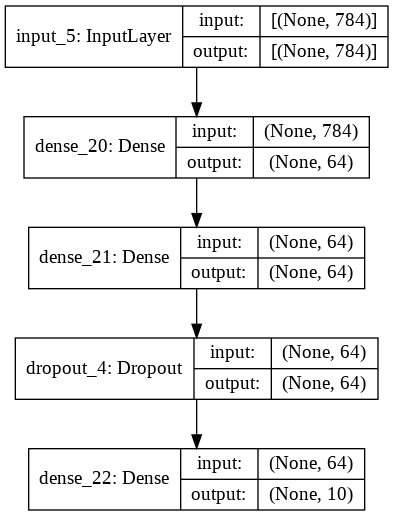

In [ ]:
#L1 regularization : LASSO
#L2 regularization : Ridge
#Dropout
#Elastic Regularization
#https://www.tensorflow.org/api_docs/python/tf/keras/regularizers
    
from tensorflow.keras.regularizers import l2

inputs = tf.keras.Input(shape=(784,))
dense = tf.keras.layers.Dense(64, activation="relu")
x = dense(inputs)

#Regularizer를 적용하고 싶다면 아래와 같이 Layer 생성시 regularizer를 넣어주자.
#Dense layer의 경우 kernel_regularizer, bias_regularizer, activity_regularizer 등을 사용가능하다.
#상세 내용은 Documentation을 참고하라. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
layer = tf.keras.layers.Dense(64, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))
x = layer(x)

# Dropout layer를 추가하여 Overfitting을 방지할 수도 있다.
dropout = tf.keras.layers.Dropout(0.3)
x = dropout(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs=outputs, name="mnist_model")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
